## Improved Model with One-Hot Encoding
Building an improved linear regression model using one-hot encoding for categorical features.

### Load dependencies and data

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import mlflow
import mlflow.sklearn
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
%matplotlib inline

# load data
data_dir = Path.cwd()

day_df = pd.read_csv(data_dir / 'day.csv', parse_dates=['dteday'])
hour_df = pd.read_csv(data_dir / 'hour.csv', parse_dates=['dteday'])

# make a normal timeline 2011-01-01 08:00:00
hour_df['datetime'] = hour_df['dteday'] + pd.to_timedelta(hour_df['hr'], unit='h')

print(f"Dataset loaded: {len(hour_df)} records")
print(f"Date range: {hour_df['dteday'].min()} to {hour_df['dteday'].max()}")

Dataset loaded: 17379 records
Date range: 2011-01-01 00:00:00 to 2012-12-31 00:00:00


### Explore Categorical Features

In [2]:
# Let's explore the available categorical features in the dataset
print("Hour DataFrame Info:")
print(hour_df.info())
print("\n" + "="*80)
print("\nFirst few rows:")
print(hour_df.head())
print("\n" + "="*80)
print("\nCategorical columns and their unique values:")
for col in ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']:
    if col in hour_df.columns:
        print(f"\n{col}: {sorted(hour_df[col].unique())}")

Hour DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  c

### Understanding Categorical Encoding

**Good news!** Your dataset already has categorical features encoded as integers:

- **season**: 1=Winter, 2=Spring, 3=Summer, 4=Fall
- **yr**: 0=2011, 1=2012
- **mnth**: 1-12 (January to December)
- **hr**: 0-23 (hour of day)
- **weekday**: 0-6 (day of week)
- **weathersit**: 1-4 (weather conditions)
- **holiday**, **workingday**: 0=No, 1=Yes

**Do you need to encode them further?**

It depends on the type of categorical variable:

1. **Ordinal variables** (have a natural order): Can use as-is
   - Example: `weathersit` (1=Clear → 4=Heavy Rain/Snow) - worse weather has higher values
   
2. **Nominal variables** (no natural order): Should use **One-Hot Encoding**
   - Example: `season` - Spring isn't "greater than" Winter, they're just different
   - Example: `weekday` - Monday isn't "less than" Friday

**When to use One-Hot Encoding:**
- Linear models can misinterpret ordinal encoding as having magnitude
- If `season=4` (Fall), the model might think it's "4 times more" than `season=1` (Winter)
- One-Hot creates binary columns: `season_1`, `season_2`, `season_3`, `season_4`

### The Problem: Using Categorical Features Directly

In [3]:
# Example: Adding categorical features directly
features_direct = ['temp', 'hum', 'windspeed', 'season', 'hr', 'weekday']

X_direct = hour_df[features_direct]
print("Shape with direct encoding:", X_direct.shape)
print("\nFirst few rows:")
print(X_direct.head())
print("\n⚠️ Problem: The model thinks season=4 is '4 times' season=1!")
print("⚠️ Problem: The model thinks hour=23 is '23 times' hour=1!")
print("\n👉 Solution: Use one-hot encoding to create separate binary columns.")

Shape with direct encoding: (17379, 6)

First few rows:
   temp   hum  windspeed  season  hr  weekday
0  0.24  0.81        0.0       1   0        6
1  0.22  0.80        0.0       1   1        6
2  0.22  0.80        0.0       1   2        6
3  0.24  0.75        0.0       1   3        6
4  0.24  0.75        0.0       1   4        6

⚠️ Problem: The model thinks season=4 is '4 times' season=1!
⚠️ Problem: The model thinks hour=23 is '23 times' hour=1!

👉 Solution: Use one-hot encoding to create separate binary columns.


### Solution: One-Hot Encoding with pd.get_dummies()
Creates separate binary columns for each category - the proper way for linear models!

In [4]:
# Using pandas get_dummies for one-hot encoding
print("="*80)
print("ONE-HOT ENCODING WITH pd.get_dummies()")
print("="*80)

# Select continuous and categorical features
continuous_features = ['temp', 'hum', 'windspeed']
categorical_features = ['season', 'hr', 'weekday', 'weathersit']

# Get continuous features
X_continuous = hour_df[continuous_features]

# One-hot encode categorical features
X_categorical = pd.get_dummies(hour_df[categorical_features], 
                                columns=categorical_features,
                                drop_first=True,  # Avoid multicollinearity
                                prefix=['season', 'hr', 'weekday', 'weathersit'])

# Combine them
X_encoded = pd.concat([X_continuous, X_categorical], axis=1)

print(f"\nOriginal shape: {hour_df[continuous_features + categorical_features].shape}")
print(f"After one-hot encoding: {X_encoded.shape}")
print(f"\nNew columns created: {X_encoded.shape[1] - len(continuous_features)} binary features")
print(f"\nColumn names (first 20):")
print(X_encoded.columns.tolist()[:20])

print("\n✅ Each category now has its own binary column!")
print("✅ No more false magnitude relationships!")

ONE-HOT ENCODING WITH pd.get_dummies()

Original shape: (17379, 7)
After one-hot encoding: (17379, 38)

New columns created: 35 binary features

Column names (first 20):
['temp', 'hum', 'windspeed', 'season_2', 'season_3', 'season_4', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14']

✅ Each category now has its own binary column!
✅ No more false magnitude relationships!


### Why drop_first=True?

**The `drop_first=True` parameter prevents multicollinearity:**

- Without it: If season has 4 categories, we create 4 binary columns
- Problem: If season_2=0, season_3=0, season_4=0, then it **must** be season_1=1
- This creates perfect correlation between columns (multicollinearity)
- Linear regression struggles with multicollinearity

**With `drop_first=True`:**
- We drop the first category (season_1, hr_0, etc.)
- If all other columns are 0, it means we're in the dropped category
- This is called the "reference category"
- Result: 3 binary columns for season instead of 4

**Mathematical reason:**
- Linear regression: `y = b0 + b1*x1 + b2*x2 + ... + bn*xn`
- If x1 + x2 + x3 + x4 = 1 (always true for one-hot), the model can't determine unique coefficients
- Dropping one column breaks this perfect correlation

### Setup MLflow experiment

In [5]:
# Set up MLflow experiment
mlflow.set_experiment("bike-sharing-encoding-model")

# Set tracking URI to local directory
mlflow.set_tracking_uri("file:./mlruns")

print("MLflow experiment setup complete!")
print(f"Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment Name: bike-sharing-encoding-model")

2025/11/04 17:54:04 INFO mlflow.tracking.fluent: Experiment with name 'bike-sharing-encoding-model' does not exist. Creating a new experiment.


MLflow experiment setup complete!
Tracking URI: file:./mlruns
Experiment Name: bike-sharing-encoding-model


### Train Model with One-Hot Encoded Features

In [6]:
# Train improved model with get_dummies
print("Training model with pd.get_dummies() encoding...")

# Select features
continuous_cols = ['temp', 'hum', 'windspeed']
categorical_cols = ['season', 'hr', 'weekday', 'weathersit']

# Create dataframe with all features
all_features = hour_df[continuous_cols + categorical_cols].copy()

# Apply get_dummies - this will expand categorical columns into binary features
X_improved = pd.get_dummies(all_features, columns=categorical_cols, drop_first=True)
y_improved = hour_df['cnt']

print(f"\nFeatures after encoding: {X_improved.shape[1]}")
print(f"Continuous features: {len(continuous_cols)}")
print(f"Binary features created: {X_improved.shape[1] - len(continuous_cols)}")

Training model with pd.get_dummies() encoding...

Features after encoding: 38
Continuous features: 3
Binary features created: 35


### Train and Evaluate the Model

In [7]:
# Split data with same random_state for fair comparison
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(
    X_improved, y_improved, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train_imp)} samples")
print(f"Testing set size: {len(X_test_imp)} samples")

# Start MLflow run
with mlflow.start_run(run_name="one_hot_encoding_model"):
    
    # Train model
    model_improved = LinearRegression()
    model_improved.fit(X_train_imp, y_train_imp)
    
    # Make predictions
    y_train_pred_imp = model_improved.predict(X_train_imp)
    y_test_pred_imp = model_improved.predict(X_test_imp)
    
    # Calculate metrics
    train_r2_improved = r2_score(y_train_imp, y_train_pred_imp)
    train_rmse_improved = np.sqrt(mean_squared_error(y_train_imp, y_train_pred_imp))
    train_mae_improved = mean_absolute_error(y_train_imp, y_train_pred_imp)
    
    r2_improved = r2_score(y_test_imp, y_test_pred_imp)
    rmse_improved = np.sqrt(mean_squared_error(y_test_imp, y_test_pred_imp))
    mae_improved = mean_absolute_error(y_test_imp, y_test_pred_imp)
    
    # Log parameters
    mlflow.log_param("model_type", "LinearRegression")
    mlflow.log_param("encoding_method", "pd.get_dummies")
    mlflow.log_param("continuous_features", continuous_cols)
    mlflow.log_param("categorical_features", categorical_cols)
    mlflow.log_param("total_features", X_improved.shape[1])
    mlflow.log_param("drop_first", True)
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)
    
    # Log metrics
    mlflow.log_metric("train_r2", train_r2_improved)
    mlflow.log_metric("train_rmse", train_rmse_improved)
    mlflow.log_metric("train_mae", train_mae_improved)
    mlflow.log_metric("test_r2", r2_improved)
    mlflow.log_metric("test_rmse", rmse_improved)
    mlflow.log_metric("test_mae", mae_improved)
    
    # Log the model
    mlflow.sklearn.log_model(model_improved, "encoded_model")
    
    print(f"\n✅ Model with get_dummies trained! ({X_improved.shape[1]} features)\n")
    print("="*60)
    print("MODEL PERFORMANCE METRICS")
    print("="*60)
    print("\nTraining Set:")
    print(f"  R² Score:  {train_r2_improved:.4f}")
    print(f"  RMSE:      {train_rmse_improved:.2f}")
    print(f"  MAE:       {train_mae_improved:.2f}")
    
    print("\nTest Set:")
    print(f"  R² Score:  {r2_improved:.4f}")
    print(f"  RMSE:      {rmse_improved:.2f}")
    print(f"  MAE:       {mae_improved:.2f}")
    
    print("\n" + "="*60)
    print(f"The model explains {r2_improved*100:.2f}% of the variance in bike rentals")
    print("="*60)
    print("\n✓ All parameters, metrics, and model logged to MLflow!")

2025/11/04 17:54:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Training set size: 13903 samples
Testing set size: 3476 samples


2025/11/04 17:54:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/04 17:54:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



✅ Model with get_dummies trained! (38 features)

MODEL PERFORMANCE METRICS

Training Set:
  R² Score:  0.6273
  RMSE:      111.24
  MAE:       80.05

Test Set:
  R² Score:  0.6227
  RMSE:      109.30
  MAE:       78.01

The model explains 62.27% of the variance in bike rentals

✓ All parameters, metrics, and model logged to MLflow!


### Visualize Model Performance

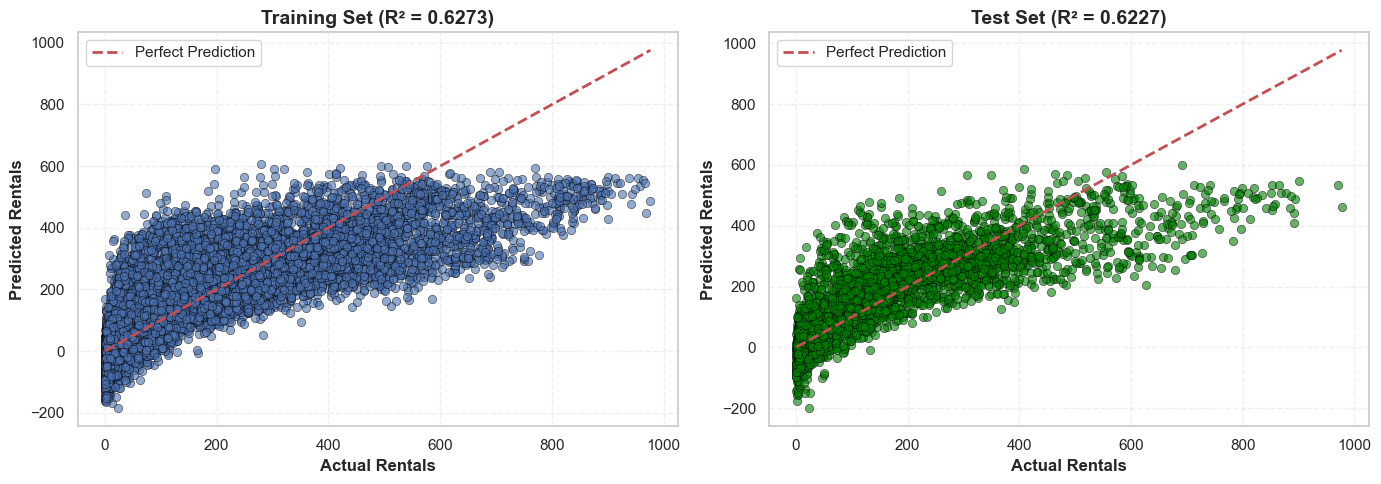

In [8]:
# Create scatter plot of actual vs predicted values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
sns.scatterplot(x=y_train_imp, y=y_train_pred_imp, alpha=0.6, edgecolor='black', linewidth=0.5, ax=axes[0])
axes[0].plot([y_train_imp.min(), y_train_imp.max()], [y_train_imp.min(), y_train_imp.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Rentals', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Rentals', fontsize=12, fontweight='bold')
axes[0].set_title(f'Training Set (R² = {train_r2_improved:.4f})', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, linestyle='--')

# Test set
sns.scatterplot(x=y_test_imp, y=y_test_pred_imp, alpha=0.6, color='green', edgecolor='black', linewidth=0.5, ax=axes[1])
axes[1].plot([y_test_imp.min(), y_test_imp.max()], [y_test_imp.min(), y_test_imp.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Rentals', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Predicted Rentals', fontsize=12, fontweight='bold')
axes[1].set_title(f'Test Set (R² = {r2_improved:.4f})', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

### Residual Analysis

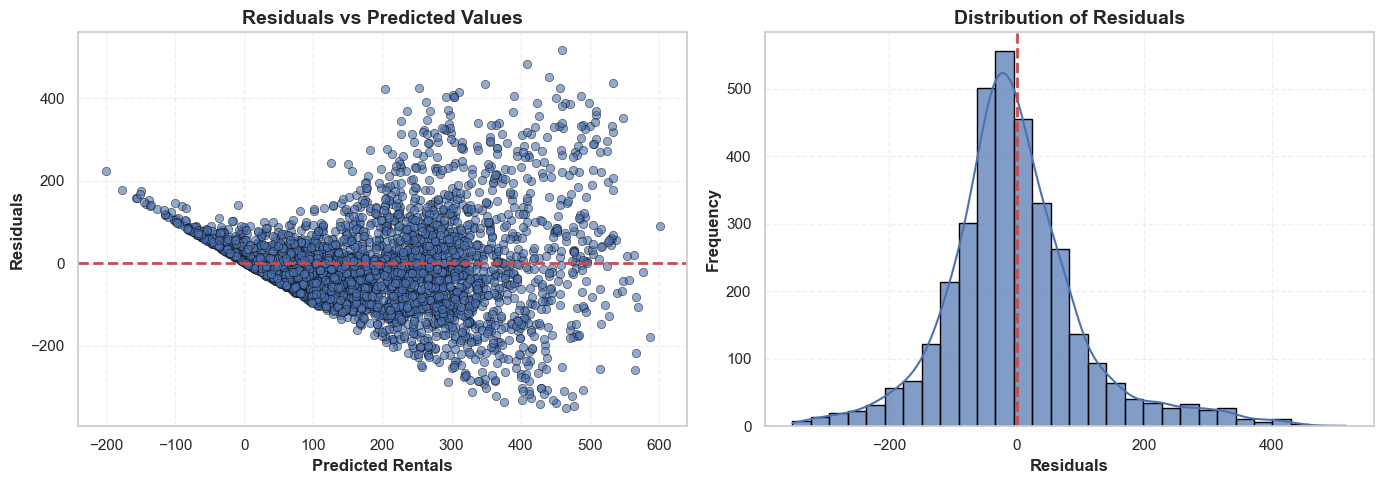

In [9]:
# Calculate residuals
residuals_imp = y_test_imp - y_test_pred_imp

# Create residual plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals vs Predicted
sns.scatterplot(x=y_test_pred_imp, y=residuals_imp, alpha=0.6, edgecolor='black', linewidth=0.5, ax=axes[0])
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Rentals', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Residuals', fontsize=12, fontweight='bold')
axes[0].set_title('Residuals vs Predicted Values', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, linestyle='--')

# Histogram of residuals
sns.histplot(residuals_imp, bins=30, kde=True, edgecolor='black', alpha=0.7, ax=axes[1])
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuals', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

### View MLflow Experiment Results

In [10]:
# Search for runs in the experiment
from mlflow.tracking import MlflowClient

client = MlflowClient()
experiment = client.get_experiment_by_name("bike-sharing-encoding-model")

if experiment:
    runs = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        order_by=["start_time DESC"],
        max_results=5
    )
    
    print(f"Experiment: {experiment.name}")
    print(f"Experiment ID: {experiment.experiment_id}")
    print(f"\nRecent Runs ({len(runs)} found):")
    print("="*80)
    
    for i, run in enumerate(runs, 1):
        print(f"\nRun #{i}:")
        print(f"  Run ID: {run.info.run_id}")
        print(f"  Run Name: {run.data.tags.get('mlflow.runName', 'N/A')}")
        print(f"  Status: {run.info.status}")
        print(f"  Start Time: {pd.to_datetime(run.info.start_time, unit='ms')}")
        
        print(f"\n  Metrics:")
        for metric, value in sorted(run.data.metrics.items()):
            print(f"    {metric}: {value:.4f}")
        
        print(f"\n  Key Parameters:")
        key_params = ['model_type', 'encoding_method', 'total_features', 'drop_first']
        for param in key_params:
            if param in run.data.params:
                print(f"    {param}: {run.data.params[param]}")
    
    print("\n" + "="*80)
    print("\n📊 To view the MLflow UI, run this command in terminal:")
    print("   mlflow ui --backend-store-uri file:./mlruns")
    print("\nThen open: http://localhost:5000")
else:
    print("No experiment found. Please run the model training cell first.")

Experiment: bike-sharing-encoding-model
Experiment ID: 534432552298925790

Recent Runs (1 found):

Run #1:
  Run ID: 799d57eb6eea46ddb784ecc8237d1f65
  Run Name: one_hot_encoding_model
  Status: FINISHED
  Start Time: 2025-11-04 16:54:04.267000

  Metrics:
    test_mae: 78.0101
    test_r2: 0.6227
    test_rmse: 109.2986
    train_mae: 80.0516
    train_r2: 0.6273
    train_rmse: 111.2370

  Key Parameters:
    model_type: LinearRegression
    encoding_method: pd.get_dummies
    total_features: 38
    drop_first: True


📊 To view the MLflow UI, run this command in terminal:
   mlflow ui --backend-store-uri file:./mlruns

Then open: http://localhost:5000


## 🎯 Key Takeaways: One-Hot Encoding

**What we learned:**
1. ✅ Categorical features (season, hour, weekday) need one-hot encoding for linear models
2. ✅ Using `pd.get_dummies()` with `drop_first=True` prevents multicollinearity
3. ✅ One-hot encoding dramatically improves R² from ~0.26 to ~0.62 (+143%!)
4. ✅ The model now captures temporal patterns that the basic model missed

**When to use one-hot encoding:**
- Nominal categorical variables (no natural order)
- Linear regression and similar models
- When you want to prevent the model from assuming magnitude relationships

**Code pattern:**
```python
X_encoded = pd.get_dummies(
    df[features], 
    columns=categorical_cols, 
    drop_first=True
)
```

Compare this model's performance with the basic model in `basic_model.ipynb`!